In [96]:
from firedrake import *
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [97]:
mesh = UnitSquareMesh(40, 40, quadrilateral=True)

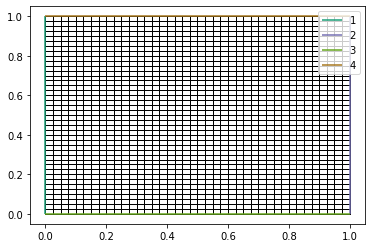

In [98]:
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();

In [99]:
V = FunctionSpace(mesh, "DQ", 1)
W = VectorFunctionSpace(mesh, "CG", 1)

In [100]:
x, y = SpatialCoordinate(mesh)

r = sqrt(pow(x-0.5, 2) + pow(y-0.5, 2))

velocity = as_vector(( (0.5 - y ) , ( x - 0.5) ))
u = Function(W).interpolate(velocity)


In [101]:
bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85

bell = 0.25*(1+cos(math.pi*min_value(sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))
cone = 1.0 - min_value(sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)
slot_cyl = conditional(sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             conditional(And(And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)

In [102]:
q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = Function(V).assign(q)

In [103]:
qs = []

In [104]:
T = 2*math.pi
dt = T/1200
dtc = Constant(dt)
q_in = Constant(1.0)

In [105]:
dq_trial = TrialFunction(V)
phi = TestFunction(V)
a = phi*dq_trial*dx

In [106]:
n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))

In [107]:
L1 = dtc*(q*div(phi*u)*dx
          - conditional(dot(u, n) < 0, phi*dot(u, n)*q_in, 0.0)*ds
          - conditional(dot(u, n) > 0, phi*dot(u, n)*q, 0.0)*ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*dS)

In [108]:
q1 = Function(V); q2 = Function(V)
L2 = replace(L1, {q: q1}); L3 = replace(L1, {q: q2})

In [109]:
dq = Function(V)

In [110]:
params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dq)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dq)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dq)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)

In [111]:
limiter = VertexBasedLimiter(V)

In [112]:
t = 0.0
step = 0
output_freq = 20

In [113]:
DG0 = FunctionSpace(mesh, "DG", 0)
qbar = Function(DG0)



In [114]:
limiter.apply(q)

In [115]:
if step % output_freq == 0:
    qs.append(q.copy(deepcopy=True))
    print("t=", t)
print(q.dat.data.max())
qbar.project(q)
q.project(qbar)
while t < T - 0.5*dt:
    solv1.solve()
    q1.assign(q + dq)
    limiter.apply(q1)

    solv2.solve()
    q1.assign(q1+dq)
    limiter.apply(q1)
    q2.assign(0.75*q + 0.25*(q1 + dq))
    limiter.apply(q2)

    solv3.solve()
    q2.assign(q2+dq)
    limiter.apply(q2)
    q.assign((1.0/3.0)*q + (2.0/3.0)*(q2 + dq))
    #limiter.apply(q)
    qbar.project(q)
    q.project(qbar)
    print(q.dat.data.max())
    step += 1
    t += dt

    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)

t= 0.0
2.0
2.005163880525329
2.000396282464683
2.0008213958503327
2.0003069347955518
2.0001569031848185
2.000167455514333
2.000049376985616
2.000050316486559
2.0000329404248496
1.9999036030897381
1.9995740076626163
1.998944317229402
1.997907192833898
1.9963549304774388
1.9943466290551668
1.9916996441399342
1.9883325098109383
1.984172258082087
1.9791559261174996
1.9732316014707125
t= 0.10471975511965971
1.9663590482945408
1.9621527223742101
1.9577492513332269
1.9524182543146613
1.9461767721837293
1.9392147769815138
1.9360552858536777
1.9319373154301045
1.9269046192454538
1.9210063421958454
1.9142965593063024
1.9069485238102775
1.898852147771894
1.890062617354342
1.8851527842076872
1.8818481597904861
1.8810079504467596
1.8791558496930965
1.8763503216670818
1.8726518365383904
t= 0.2094395102393196
1.8681228130310683
1.8628274946429257
1.8568355134968118
1.8516706868072417
1.8498665134194014
1.8472730010659546
1.8439394033018133
1.8399194126199625
1.8354619672344825
1.8303696610514624
1.82

/home/molinhan/firedrake/lib/python3.8/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


1.426974779949993
1.426675813471351
1.4263052121926563
1.4258634319366812
1.4253482066251468
1.4247598402884114
1.4241028429449651
1.4233776549913417
1.42267463261678
1.4226230198671288
t= 2.5132741228718274
1.4225219042935258
1.4223536964289727
1.4221184422423472
1.4218162367989653
1.4214472219953151
1.421011584556857
1.4205095542462407
1.4199414022812036
1.4193074405450095
1.4186078196541
1.4185512769363475
1.4185270700431007
1.418437220074877
1.4182820062456654
1.4180614431590817
1.417775247288121
1.4174239543293594
1.4170077596926514
1.416526891579362
1.4159816166238266
t= 2.6179938779914895
1.4153722361716037
1.4146990857780408
1.414275919023616
1.4142518138444156
1.4141688681371105
1.4140208968491388
1.4138080933124952
1.4135305182462576
1.4131864639506384
1.4127782301346619
1.4123038288266405
1.411766022240896
1.4111650824663295
1.4105013343999422
1.409775136118749
1.409320786124632
1.4092088747191538
1.4090415290081268
1.4088092810767503
1.408512370261065
t= 2.7227136331111517


In [116]:
L2_err = sqrt(assemble((q - q_init)*(q - q_init)*dx))
L2_init = sqrt(assemble(q_init*q_init*dx))
print(L2_err/L2_init)

0.21760218456604818


In [117]:
nsp = 16
fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

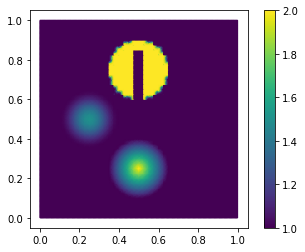

In [118]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(q_init, num_sample_points=nsp, vmin=1, vmax=2, axes=axes)
fig.colorbar(colors)

In [119]:
def animate(q):
    colors.set_array(fn_plotter(q))

In [120]:
interval = 1e3 * output_freq * dt
animation = FuncAnimation(fig, animate, frames=qs, interval=interval)
#try:
    #animation.save("DG_advection_oscitrail3.mp4", writer="ffmpeg")
#except:
    #print("Failed to write movie! Try installing `ffmpeg`.")